In [1]:
#We are trying to design a multi-headed neural network using keras api. Which will
#take in consideration both the images and its meta-data to work better.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pydot
from keras.utils.vis_utils import plot_model
import PIL.Image as pil
from tensorflow.data import AUTOTUNE

In [3]:
inputs_Im = tf.keras.Input(shape=(150,150,3),name='image')
x=tfl.Conv2D(16,(3,3),activation='relu')(inputs_Im)
x=tfl.Conv2D(16,(3,3),activation='relu')(x)
x=tfl.MaxPool2D((2,2))(x)

x=tfl.Conv2D(32,(3,3),activation='relu')(x)
x=tfl.Conv2D(32,(3,3),activation='relu')(x)
x=tfl.MaxPool2D((2,2))(x)

x=tfl.Conv2D(64,(3,3),activation='relu')(x)
x=tfl.Conv2D(64,(3,3),activation='relu')(x)
x=tfl.MaxPool2D((2,2))(x)

x=tfl.Flatten()(x)

In [105]:
inputs_Md=tf.keras.Input(shape=(12,),name='meta-data')
y=tfl.Dense(512,activation='relu')(inputs_Md)
y=tfl.Dense(512,activation='relu')(y)

y=tfl.Dense(300,activation='relu')(y)
y=tfl.Dense(300,activation='relu')(y)

y=tfl.Dense(50,activation='relu')(y)

In [106]:
z=tfl.Concatenate()([x,y])
z=tfl.Dense(1024,activation='relu')(z)
z=tfl.Dense(1024,activation='relu')(z)

z=tfl.Dense(64,activation='relu')(z)

output=tfl.Dense(1,activation='relu',name='pawp')(z)

In [107]:
model = tf.keras.Model(
    inputs=[inputs_Im, inputs_Md],
    outputs=output
)

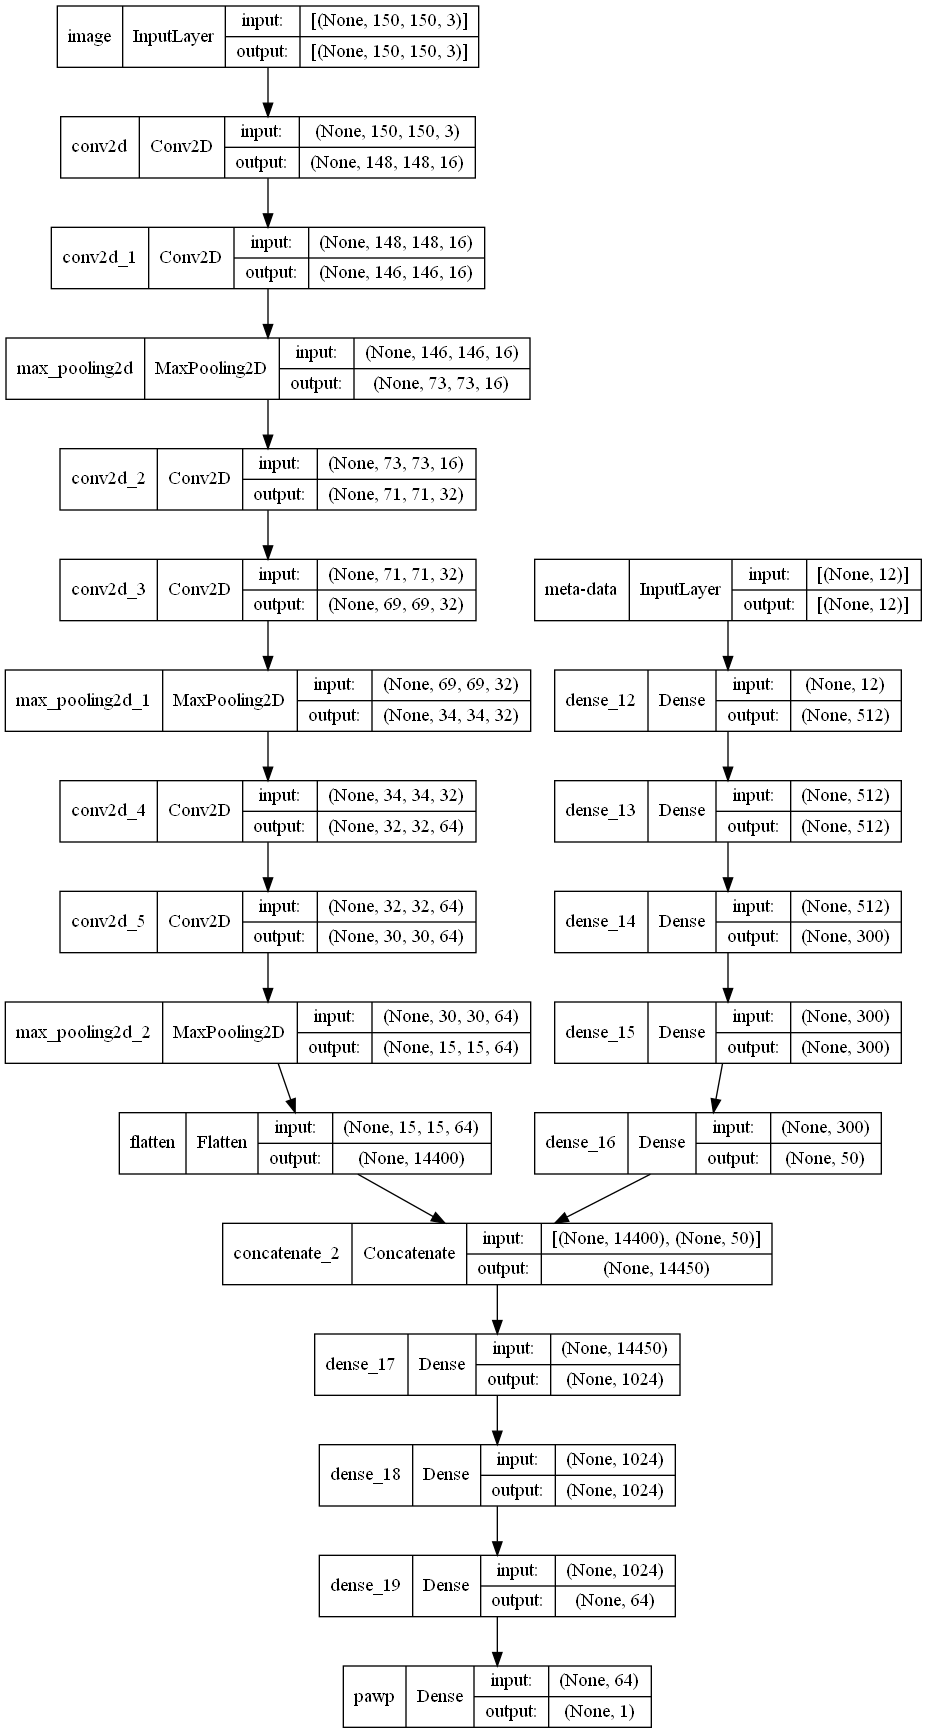

In [108]:
plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [8]:
#Designing the input pipeline for our data
#First we will prepare a CSV containing all the data along with the image paths
df= pd.read_csv("train.csv")
df['Id'] = df['Id'].apply(lambda x:"./train/" + x + ".jpg")
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,./train/0007de18844b0dbbb5e1f607da0606e0.jpg,0,1,1,1,0,0,1,0,0,0,0,0,63
1,./train/0009c66b9439883ba2750fb825e1d7db.jpg,0,1,1,0,0,0,0,0,0,0,0,0,42
2,./train/0013fd999caf9a3efe1352ca1b0d937e.jpg,0,1,1,1,0,0,0,0,1,1,0,0,28
3,./train/0018df346ac9c1d8413cfcc888ca8246.jpg,0,1,1,1,0,0,0,0,0,0,0,0,15
4,./train/001dc955e10590d3ca4673f034feeef2.jpg,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,./train/ffbfa0383c34dc513c95560d6e1fdb57.jpg,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,./train/ffcc8532d76436fc79e50eb2e5238e45.jpg,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,./train/ffdf2e8673a1da6fb80342fa3b119a20.jpg,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,./train/fff19e2ce11718548fa1c5d039a5192a.jpg,0,1,1,1,0,0,0,0,1,0,0,0,20


In [111]:
a = dict(df)
type(a["Id"])

pandas.core.series.Series

In [102]:
from pprint import pprint
def load_images(data):
    pprint({d:type(data[d]) for d in data.keys()})
    # This function is respnsible for loading the images and the relating data 
    imagePath=data["Id"]
    print(f"imagePath = {imagePath}")
    pawp=float(data['Pawpularity']) # @Diptarko remove float type casting
    '''
    del data["Id"]
    del data["Pawpularity"]
    Consider data list
    attr=data[:,1:-2]
    '''
    attr=data["Subject Focus"]
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (150, 150)) / 255.0
    # return the image and the integer encoded label
    return ({"image":image, "meta-data":attr}, {"pawp":pawp})

In [103]:
print(" creating a tf.data input pipeline..")
BS=32
dataset = tf.data.Dataset.from_tensor_slices(dict(df))
# print(f"dataset = {dataset}\n")
# print(f"dataset type = {type(dataset)}\n")
dataset = (dataset
	.shuffle(1024)
	.map(load_images, num_parallel_calls=AUTOTUNE)
	.cache()
	.repeat()
	.batch(BS)
	.prefetch(AUTOTUNE)
)

 creating a tf.data input pipeline..
{'Accessory': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Action': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Blur': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Collage': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Eyes': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Face': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Group': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Human': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Id': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Info': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Near': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Occlusion': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Pawpularity': <class 'tensorflow.python.framework.ops.Tensor'>,
 'Subject Focus': <class 'tensorflow.python.framework.ops.Tensor'>}
imagePath = Tensor("args_8:0", shape=(), dtype=string)


In [ ]:
print

In [88]:
dataset.element_spec

({'image': TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
  'attr': TensorSpec(shape=(None,), dtype=tf.int64, name=None)},
 {'pawp': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})

In [100]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        beta_1=0.9,
        beta_2=0.999),
        loss='MeanSquaredError',
        metrics=['RootMeanSquaredError']
    
)

In [104]:
model.fit(
	dataset,
    steps_per_epoch=100,
	epochs=10,
	verbose=1)

Epoch 1/10
100/100 [==============================] - 14s 76ms/step - loss: 285897.5312 - root_mean_squared_error: 534.6938
Epoch 2/10
100/100 [==============================] - 8s 75ms/step - loss: 452.0302 - root_mean_squared_error: 21.2610 0s - loss: 446.4534 - root_mean_squared_error: 2
Epoch 3/10
100/100 [==============================] - 9s 86ms/step - loss: 420.5323 - root_mean_squared_error: 20.5069
Epoch 4/10
100/100 [==============================] - 6s 57ms/step - loss: 462.6486 - root_mean_squared_error: 21.5093
Epoch 5/10
100/100 [==============================] - 6s 59ms/step - loss: 445.5005 - root_mean_squared_error: 21.1069
Epoch 6/10
100/100 [==============================] - 6s 60ms/step - loss: 420.6266 - root_mean_squared_error: 20.5092
Epoch 7/10
100/100 [==============================] - 6s 56ms/step - loss: 452.8500 - root_mean_squared_error: 21.2803
Epoch 8/10
 30/100 [========>.....................] - ETA: 4s - loss: 453.4208 - root_mean_squared_error: 21.2937

KeyboardInterrupt: 